# 1. Importing Dependencies


## 1.1 Importing Dependency Packages

In [23]:

import pandas as pd  # Importing pandas library for data manipulation and analysis
import seaborn as sns  # Importing seaborn library for statistical data visualization
import matplotlib.pyplot as plt  # Importing matplotlib library for creating visualizations
import numpy as np  # Importing numpy library for numerical computations
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

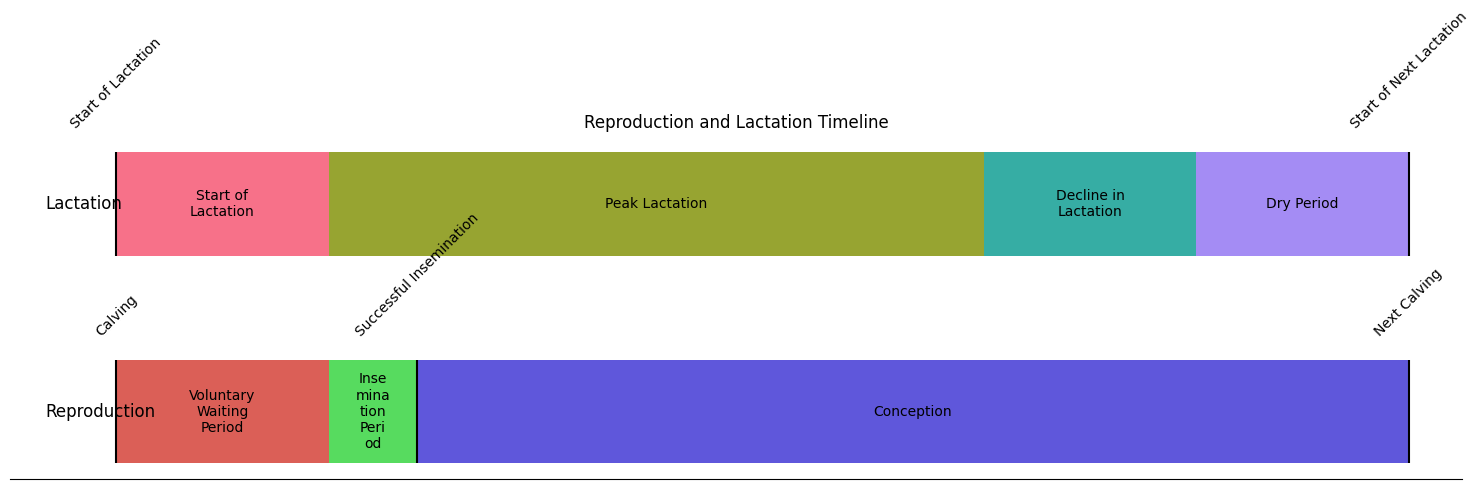

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Define the periods for reproduction
reproduction_periods = {
    'Voluntary Waiting Period': (0, 60),
    'Insemination Period': (60, 85),
    'Conception': (85, 365),
}

# Define the periods for lactation
lactation_periods = {
    'Start of Lactation': (0, 60),
    'Peak Lactation': (60, 245),
    'Decline in Lactation': (245, 305),
    'Dry Period': (305, 365),
}

# Define events for reproduction
reproduction_events = {
    'Calving': 0,
    'Successful Insemination': 85,
    'Next Calving': 365,
}

# Define events for lactation
lactation_events = {
    'Start of Lactation': 0,
    'Start of Next Lactation': 365,
}

# Function to draw a timeline
def draw_timeline(ax, periods, events, title, ylevel, label, color_palette):
    colors = sns.color_palette(color_palette, len(periods))
    # Draw a colored bar for each period
    for i, (period, (start, end)) in enumerate(periods.items()):
        ax.broken_barh([(start, end-start)], (ylevel, 0.1), facecolors=colors[i])
        period_center = start + (end-start)/2
        # Wrap the text if it is too long
        wrapped_period = textwrap.fill(period, width=max(1, int((end-start)/6)))
        ax.text(period_center, ylevel+0.05, wrapped_period, ha='center', va='center')

    # Draw vertical lines and text for each event
    for event, day in events.items():
        ax.vlines(day, ylevel, ylevel+0.1, color='black')
        ax.text(day, ylevel+0.12, event, rotation=45, va='bottom', ha='center')

    # Add label
    ax.text(-20, ylevel+0.05, label, va='center', fontsize=12)

    # Set title
    ax.set_title(title)

fig, ax = plt.subplots(figsize=(15, 5))

# Draw the timelines
draw_timeline(ax, reproduction_periods, reproduction_events, 'Reproduction and Lactation Timeline', 0.2, 'Reproduction', 'hls')
draw_timeline(ax, lactation_periods, lactation_events, 'Reproduction and Lactation Timeline', 0.4, 'Lactation', 'husl')

# Remove y-axis and spines
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set x-axis limit
ax.set_xlim([-30, 380])

plt.tight_layout()
plt.show()

In [26]:
storage = {
    "model": None,
    "scaler": None,
    "means": None
}

## 1.2. Mounting Google Drive

## 1.3 Loading the Main Data

In [27]:
columns = ['Serial', 'AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
       'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
       'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
       'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
       'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'LengthInDays',
       'DaysOpen', 'TimesBred', 'Lameness', 'Mastities', 'Ketosis',
       'RetainedPlacentra', 'DisplacedAbomasam', 'Winter', 'Spring', 'Summer',
       'Fall']

In [28]:
# Detect outliers in numerical columns
numeric_columns = ['AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA', 'AgeAtCalvingInDays',
       'AgeAtCalvingInMonths', 'MostRecentBodyScore', 'MostRecentMotionScore',
       'AverageBodyScore', 'AverageMotionScore', 'InbreedingCoefficient',
       'PregnancyLengthMonths', 'Milk',
       'MilkDays', 'MilkFat', 'MilkProtein',
       'DIMAtBreeding', 'Lactation',
       'LengthInDays', 'DaysOpen', 'TimesBred', 'AverageMilk', 'ECM',
       'FatProteinRatio']

In [29]:
# Use the Pandas library to read the CSV file
data = pd.read_csv('days-open-v9.csv', dtype= {'Serial': str}, names= columns)

In [30]:
data.shape

(16472, 33)

In [31]:
data

,Serial,AgeAtCalvingInDaysA,AgeAtCalvingInMonthsA,AgeAtCalvingInDays,AgeAtCalvingInMonths,MostRecentBodyScore,MostRecentMotionScore,AverageBodyScore,AverageMotionScore,InbreedingCoefficient,...,TimesBred,Lameness,Mastities,Ketosis,RetainedPlacentra,DisplacedAbomasam,Winter,Spring,Summer,Fall
0,3251371042900290,775,26,1184,39,NaN,NaN,NaN,NaN,0.097656,...,0,0,0,0,0,0,0,0,0,1
1,3251371042900290,1184,39,1521,50,NaN,NaN,NaN,NaN,0.097656,...,0,0,0,0,0,0,0,0,1,1
2,3251370011400010,1545,50,1890,62,NaN,NaN,NaN,NaN,0.000000,...,1,0,0,0,0,0,0,1,1,0
3,3251370011400010,1890,62,2070,68,NaN,NaN,NaN,NaN,0.000000,...,1,0,0,0,0,0,1,0,0,1
4,3251370011400010,2070,68,2843,93,NaN,NaN,NaN,NaN,0.000000,...,4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,3251388033002190,1991,66,2277,75,3.50,NaN,4.305556,NaN,0.720215,...,3,0,0,0,1,0,0,0,1,1
16468,3251386091305310,3630,119,4025,132,4.25,2.0,4.409091,2.0,0.073242,...,3,0,0,0,0,0,1,0,0,1
16469,3251387012800560,1934,64,2283,75,4.50,NaN,4.416667,NaN,0.000000,...,1,0,0,0,1,0,0,0,1,0
16470,3251382030300980,2174,72,2601,86,4.50,NaN,4.500000,NaN,0.195313,...,5,0,0,0,0,0,0,0,1,0


In [32]:
data['Serial'].nunique()

5557

In [33]:
data.columns

Index(['Serial', 'AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
       'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
       'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
       'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
       'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'LengthInDays',
       'DaysOpen', 'TimesBred', 'Lameness', 'Mastities', 'Ketosis',
       'RetainedPlacentra', 'DisplacedAbomasam', 'Winter', 'Spring', 'Summer',
       'Fall'],
      dtype='object')

In [34]:
data.describe()['DaysOpen']

count    16470.000000
mean       140.967031
std        142.909587
min      -1186.000000
25%         68.000000
50%        105.000000
75%        168.000000
max       3399.000000
Name: DaysOpen, dtype: float64

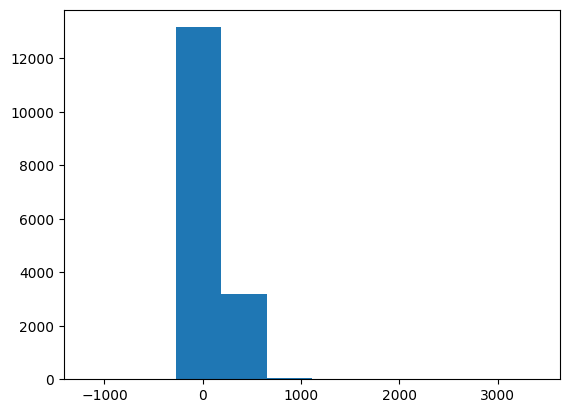

In [35]:
plt.hist(data['DaysOpen'])
plt.show()

In [36]:
logical_data = data.copy()

In [37]:
logical_data = logical_data[(logical_data['AgeAtCalvingInMonthsA'] > 20)]
logical_data.shape

(16280, 33)

In [38]:
logical_data = logical_data[(logical_data['AgeAtCalvingInMonths'] > 20)]
logical_data.shape

(16280, 33)

In [39]:
logical_data = logical_data[(logical_data['AverageBodyScore'] >= 1) & (logical_data['AverageBodyScore'] <= 9)]
logical_data.shape

(11562, 33)

In [40]:
# logical_data = logical_data[(logical_data['DaysOpen'] >= 70) & (logical_data['DaysOpen'] <= 365)]
logical_data.shape

(11562, 33)

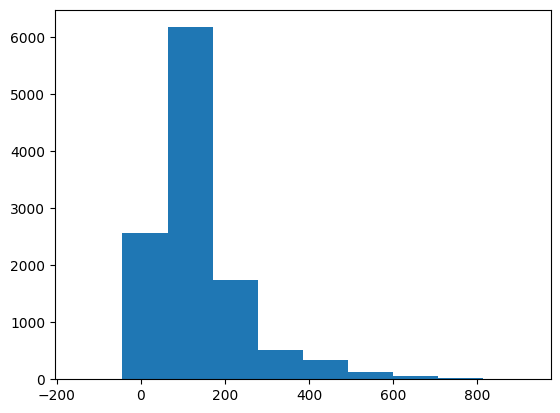

In [41]:
plt.hist(logical_data['DaysOpen'])
plt.show()

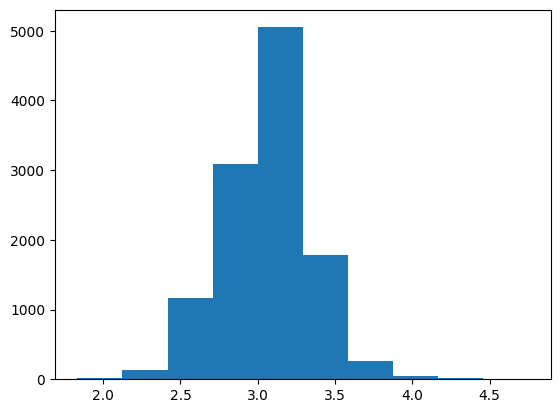

In [42]:
plt.hist(logical_data['AverageBodyScore'])
plt.show()

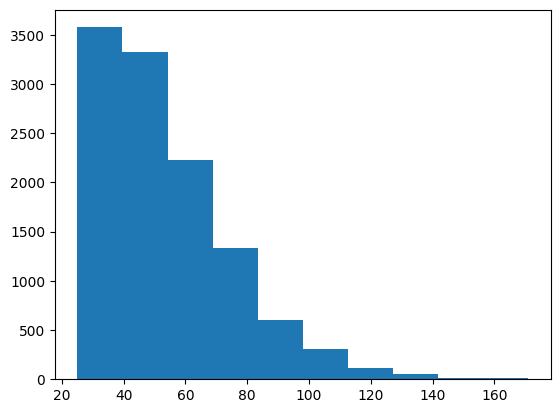

In [43]:
plt.hist(logical_data['AgeAtCalvingInMonths'])
plt.show()

In [44]:
data = logical_data

# 2. Data Processing
In this part we use process the data, merge it disorders data and then clean the data, remove the outliers and normalize it to be ready for the model

In [45]:
data.shape

(11562, 33)

In [46]:
data

,Serial,AgeAtCalvingInDaysA,AgeAtCalvingInMonthsA,AgeAtCalvingInDays,AgeAtCalvingInMonths,MostRecentBodyScore,MostRecentMotionScore,AverageBodyScore,AverageMotionScore,InbreedingCoefficient,...,TimesBred,Lameness,Mastities,Ketosis,RetainedPlacentra,DisplacedAbomasam,Winter,Spring,Summer,Fall
4757,3251389070105150,1418,47,1606,53,1.75,3.0,1.833333,3.0,0.000000,...,2,0,0,0,0,0,1,0,0,0
4758,3251387112506750,1513,50,2105,69,2.50,NaN,2.031250,NaN,4.687500,...,3,0,0,0,0,0,0,0,0,1
4759,3251387112506750,1824,60,2105,69,2.50,NaN,2.031250,NaN,4.687500,...,2,0,0,0,0,0,0,0,0,1
4760,3251390032502390,1037,34,1435,47,1.75,NaN,2.050000,NaN,NaN,...,2,0,0,0,0,0,0,1,0,0
4761,3251385090704880,2832,93,3126,103,2.25,3.0,2.055556,4.0,1.129151,...,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,3251388033002190,1991,66,2277,75,3.50,NaN,4.305556,NaN,0.720215,...,3,0,0,0,1,0,0,0,1,1
16468,3251386091305310,3630,119,4025,132,4.25,2.0,4.409091,2.0,0.073242,...,3,0,0,0,0,0,1,0,0,1
16469,3251387012800560,1934,64,2283,75,4.50,NaN,4.416667,NaN,0.000000,...,1,0,0,0,1,0,0,0,1,0
16470,3251382030300980,2174,72,2601,86,4.50,NaN,4.500000,NaN,0.195313,...,5,0,0,0,0,0,0,0,1,0


In [47]:
data.describe()

,AgeAtCalvingInDaysA,AgeAtCalvingInMonthsA,AgeAtCalvingInDays,AgeAtCalvingInMonths,MostRecentBodyScore,MostRecentMotionScore,AverageBodyScore,AverageMotionScore,InbreedingCoefficient,PregnancyLengthMonths,...,TimesBred,Lameness,Mastities,Ketosis,RetainedPlacentra,DisplacedAbomasam,Winter,Spring,Summer,Fall
count,11562.000000,11562.000000,11562.000000,11562.000000,11562.000000,5367.000000,11562.000000,5367.00000,3983.000000,11562.000000,...,11562.000000,11562.000000,11562.000000,11562.000000,11562.000000,11562.000000,11562.000000,11562.000000,11562.000000,11562.000000
mean,1258.446636,41.342588,1651.241221,54.248227,3.012457,2.055152,3.056690,2.11050,2.972212,8.343020,...,2.444906,0.075074,0.026120,0.011244,0.057862,0.011676,0.294499,0.292164,0.330825,0.305224
std,612.157858,20.118957,630.758765,20.727779,0.371277,0.999410,0.284378,0.81063,5.950162,1.882262,...,1.771904,0.263521,0.159499,0.105443,0.233492,0.107428,0.455837,0.454777,0.470531,0.460522
min,612.000000,21.000000,750.000000,25.000000,1.500000,1.000000,1.833333,1.00000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,730.000000,24.000000,1130.000000,37.000000,2.750000,1.000000,2.865385,1.50000,0.000000,9.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1087.000000,36.000000,1491.500000,49.000000,3.000000,2.000000,3.077778,2.00000,0.473022,9.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1550.000000,51.000000,1971.000000,65.000000,3.250000,3.000000,3.238889,2.50000,3.253173,9.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,4940.000000,162.000000,5205.000000,171.000000,6.750000,5.000000,4.750000,5.00000,56.115723,16.000000,...,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
data['AverageMilk'] = data['Milk'] / data['MilkDays']

In [49]:
mask = np.isnan(data["MilkFat"]) | np.isnan(data["MilkProtein"]) | np.isnan(data["Milk"])

data["ECM"] = np.nan
data.loc[~mask, "ECM"] = 0.327 * data["Milk"] + 12.95 * data["MilkFat"] + 7.65 * data["MilkProtein"]



In [50]:

data["FatProteinRatio"] = np.nan
data.loc[~mask, "FatProteinRatio"] = data["MilkFat"] / data["MilkProtein"]


In [51]:
data

,Serial,AgeAtCalvingInDaysA,AgeAtCalvingInMonthsA,AgeAtCalvingInDays,AgeAtCalvingInMonths,MostRecentBodyScore,MostRecentMotionScore,AverageBodyScore,AverageMotionScore,InbreedingCoefficient,...,Ketosis,RetainedPlacentra,DisplacedAbomasam,Winter,Spring,Summer,Fall,AverageMilk,ECM,FatProteinRatio
4757,3251389070105150,1418,47,1606,53,1.75,3.0,1.833333,3.0,0.000000,...,0,0,0,1,0,0,0,33.905290,3248.49975,NaN
4758,3251387112506750,1513,50,2105,69,2.50,NaN,2.031250,NaN,4.687500,...,0,0,0,0,0,0,1,NaN,NaN,NaN
4759,3251387112506750,1824,60,2105,69,2.50,NaN,2.031250,NaN,4.687500,...,0,0,0,0,0,0,1,NaN,NaN,NaN
4760,3251390032502390,1037,34,1435,47,1.75,NaN,2.050000,NaN,NaN,...,0,0,0,0,1,0,0,31.724023,2759.41893,NaN
4761,3251385090704880,2832,93,3126,103,2.25,3.0,2.055556,4.0,1.129151,...,0,0,0,0,1,1,0,28.922913,3376.43196,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,3251388033002190,1991,66,2277,75,3.50,NaN,4.305556,NaN,0.720215,...,0,1,0,0,0,1,1,NaN,NaN,NaN
16468,3251386091305310,3630,119,4025,132,4.25,2.0,4.409091,2.0,0.073242,...,0,0,0,1,0,0,1,44.493436,4233.86193,NaN
16469,3251387012800560,1934,64,2283,75,4.50,NaN,4.416667,NaN,0.000000,...,0,1,0,0,0,1,0,NaN,NaN,NaN
16470,3251382030300980,2174,72,2601,86,4.50,NaN,4.500000,NaN,0.195313,...,0,0,0,0,0,1,0,28.428000,2231.02944,NaN


In [52]:

# Check the data types and missing values
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 11562 entries, 4757 to 16471
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Serial                 11562 non-null  object 
 1   AgeAtCalvingInDaysA    11562 non-null  int64  
 2   AgeAtCalvingInMonthsA  11562 non-null  int64  
 3   AgeAtCalvingInDays     11562 non-null  int64  
 4   AgeAtCalvingInMonths   11562 non-null  int64  
 5   MostRecentBodyScore    11562 non-null  float64
 6   MostRecentMotionScore  5367 non-null   float64
 7   AverageBodyScore       11562 non-null  float64
 8   AverageMotionScore     5367 non-null   float64
 9   InbreedingCoefficient  3983 non-null   float64
 10  PregnancyLengthMonths  11562 non-null  float64
 11  Milk                   3751 non-null   float64
 12  MilkDays               3751 non-null   float64
 13  MilkFat                3751 non-null   float64
 14  MilkProtein            3751 non-null   float64
 15  Stil

In [53]:
data.columns

Index(['Serial', 'AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
       'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
       'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
       'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
       'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'LengthInDays',
       'DaysOpen', 'TimesBred', 'Lameness', 'Mastities', 'Ketosis',
       'RetainedPlacentra', 'DisplacedAbomasam', 'Winter', 'Spring', 'Summer',
       'Fall', 'AverageMilk', 'ECM', 'FatProteinRatio'],
      dtype='object')

In [54]:


outliers = data[numeric_columns].apply(lambda x: (x - x.mean()).abs() > 3 * x.std())
outlier_counts = outliers.sum()

outlier_counts


AgeAtCalvingInDaysA      167
AgeAtCalvingInMonthsA    169
AgeAtCalvingInDays       163
AgeAtCalvingInMonths     159
MostRecentBodyScore       57
MostRecentMotionScore      0
AverageBodyScore          75
AverageMotionScore        48
InbreedingCoefficient     84
PregnancyLengthMonths    255
Milk                      29
MilkDays                  71
MilkFat                   20
MilkProtein               15
DIMAtBreeding            281
Lactation                233
LengthInDays             203
DaysOpen                 281
TimesBred                250
AverageMilk               11
ECM                       33
FatProteinRatio           17
dtype: int64

In [55]:
standard_data = data.copy()  # Create a copy of the original DataFrame
# Handling outliers
for column in numeric_columns:
    mean = standard_data[column].mean()
    std = standard_data[column].std()
    upper_bound = mean + 3 * std
    lower_bound = mean - 3 * std

    standard_data.loc[:, column] = standard_data.loc[:, column].clip(lower=lower_bound, upper=upper_bound)

standard_data.describe()


,AgeAtCalvingInDaysA,AgeAtCalvingInMonthsA,AgeAtCalvingInDays,AgeAtCalvingInMonths,MostRecentBodyScore,MostRecentMotionScore,AverageBodyScore,AverageMotionScore,InbreedingCoefficient,PregnancyLengthMonths,...,Ketosis,RetainedPlacentra,DisplacedAbomasam,Winter,Spring,Summer,Fall,AverageMilk,ECM,FatProteinRatio
count,11562.000000,11562.000000,11562.000000,11562.000000,11562.000000,5367.000000,11562.000000,5367.000000,3983.000000,11562.000000,...,11562.000000,11562.000000,11562.000000,11562.000000,11562.000000,11562.000000,11562.000000,3751.000000,3751.000000,1868.000000
mean,1252.150724,41.136413,1645.238571,54.051169,3.011033,2.055152,3.056043,2.106707,2.742136,8.360070,...,0.011244,0.057862,0.011676,0.294499,0.292164,0.330825,0.305224,36.809746,6692.513209,0.966186
std,588.954289,19.359200,608.815643,20.007319,0.362664,0.999410,0.280753,0.798092,4.709868,1.824319,...,0.105443,0.233492,0.107428,0.455837,0.454777,0.470531,0.460522,8.644947,4236.122005,0.201075
min,612.000000,21.000000,750.000000,25.000000,1.898628,1.000000,2.203555,1.000000,0.000000,2.696234,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.756710,366.838410,0.342458
25%,730.000000,24.000000,1130.000000,37.000000,2.750000,1.000000,2.865385,1.500000,0.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.569756,3601.983510,0.847982
50%,1087.000000,36.000000,1491.500000,49.000000,3.000000,2.000000,3.077778,2.000000,0.473022,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.217411,4996.291860,0.977519
75%,1550.000000,51.000000,1971.000000,65.000000,3.250000,3.000000,3.238889,2.500000,3.253173,9.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,42.296600,9298.396455,1.095016
max,3094.920211,101.699458,3543.517517,116.431564,4.126287,5.000000,3.909826,4.542389,20.822699,13.989806,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,62.872396,19593.064628,1.592127


In [56]:
# Check the number of missing values in each column
missing_values_count = standard_data.isnull().sum()
print(missing_values_count)


Serial                      0
AgeAtCalvingInDaysA         0
AgeAtCalvingInMonthsA       0
AgeAtCalvingInDays          0
AgeAtCalvingInMonths        0
MostRecentBodyScore         0
MostRecentMotionScore    6195
AverageBodyScore            0
AverageMotionScore       6195
InbreedingCoefficient    7579
PregnancyLengthMonths       0
Milk                     7811
MilkDays                 7811
MilkFat                  7811
MilkProtein              7811
StillBirth                  0
Abortion                    0
DIMAtBreeding               0
Lactation                   0
MultiBirth                  0
NaturalBreeding             0
LengthInDays                0
DaysOpen                    0
TimesBred                   0
Lameness                    0
Mastities                   0
Ketosis                     0
RetainedPlacentra           0
DisplacedAbomasam           0
Winter                      0
Spring                      0
Summer                      0
Fall                        0
AverageMil

In [57]:
import pandas as pd

filled_data = standard_data.copy()  # Create a copy of the original DataFrame


mean_values = {}  # Dictionary to store the mean values

# fill NaN values with mean value of each column
for col in numeric_columns:
    mean_val = filled_data[col].mean()
    mean_values[col] = mean_val  # Save the mean value for each column
    filled_data[col].fillna(mean_val, inplace=True)

storage["means"] = mean_values
# Confirm the changes and check the missing values again
missing_values_count = filled_data.isnull().sum()
print(missing_values_count)


Serial                   0
AgeAtCalvingInDaysA      0
AgeAtCalvingInMonthsA    0
AgeAtCalvingInDays       0
AgeAtCalvingInMonths     0
MostRecentBodyScore      0
MostRecentMotionScore    0
AverageBodyScore         0
AverageMotionScore       0
InbreedingCoefficient    0
PregnancyLengthMonths    0
Milk                     0
MilkDays                 0
MilkFat                  0
MilkProtein              0
StillBirth               0
Abortion                 0
DIMAtBreeding            0
Lactation                0
MultiBirth               0
NaturalBreeding          0
LengthInDays             0
DaysOpen                 0
TimesBred                0
Lameness                 0
Mastities                0
Ketosis                  0
RetainedPlacentra        0
DisplacedAbomasam        0
Winter                   0
Spring                   0
Summer                   0
Fall                     0
AverageMilk              0
ECM                      0
FatProteinRatio          0
dtype: int64


In [58]:
# To have just days open
# filled_data.drop(['AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
#        'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
#        'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
#        'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
#        'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
#         'MultiBirth', 'NaturalBreeding', 'LengthInDays',
#         'TimesBred', 'Lameness', 'Mastities', 'Ketosis',
#        'RetainedPlacentra', 'DisplacedAbomasam', 'Winter', 'Summer',
#        'Fall', 'ECM', 'FatProteinRatio', 'AverageMilk'], axis=1, inplace=True)


# # To have good features
filled_data.drop(['DIMAtBreeding', 'AgeAtCalvingInDaysA',
                  'AgeAtCalvingInMonthsA', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
                  'MostRecentMotionScore', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
                  'MilkProtein', 'MilkFat', 'LengthInDays'], axis=1, inplace=True)


In [59]:
#filled_data = filled_data[(filled_data['DaysOpen'] > 70) & (filled_data['DaysOpen'] <= 200)]


In [60]:
#filled_data = filled_data[filled_data['NextDaysOpen'] > 70 ]

In [61]:
filled_data

,Serial,AgeAtCalvingInDays,AverageBodyScore,AverageMotionScore,InbreedingCoefficient,StillBirth,Abortion,Lactation,MultiBirth,NaturalBreeding,...,Ketosis,RetainedPlacentra,DisplacedAbomasam,Winter,Spring,Summer,Fall,AverageMilk,ECM,FatProteinRatio
4757,3251389070105150,1606.000000,2.203555,3.000000,0.000000,0,1,3.000000,0,0,...,0,0,0,1,0,0,0,33.905290,3248.499750,0.966186
4758,3251387112506750,2105.000000,2.203555,2.106707,4.687500,0,1,3.000000,0,0,...,0,0,0,0,0,0,1,36.809746,6692.513209,0.966186
4759,3251387112506750,2105.000000,2.203555,2.106707,4.687500,0,1,3.000000,0,0,...,0,0,0,0,0,0,1,36.809746,6692.513209,0.966186
4760,3251390032502390,1435.000000,2.203555,2.106707,2.742136,0,0,2.000000,0,0,...,0,0,0,0,1,0,0,31.724023,2759.418930,0.966186
4761,3251385090704880,3126.000000,2.203555,4.000000,1.129151,0,1,6.000000,0,0,...,0,0,0,0,1,1,0,28.922913,3376.431960,0.966186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,3251388033002190,2277.000000,3.909826,2.106707,0.720215,0,1,3.000000,0,0,...,0,1,0,0,0,1,1,36.809746,6692.513209,0.966186
16468,3251386091305310,3543.517517,3.909826,2.000000,0.073242,1,0,6.906012,1,0,...,0,0,0,1,0,0,1,44.493436,4233.861930,0.966186
16469,3251387012800560,2283.000000,3.909826,2.106707,0.000000,0,0,3.000000,0,0,...,0,1,0,0,0,1,0,36.809746,6692.513209,0.966186
16470,3251382030300980,2601.000000,3.909826,2.106707,0.195313,0,0,5.000000,0,1,...,0,0,0,0,0,1,0,28.428000,2231.029440,0.966186


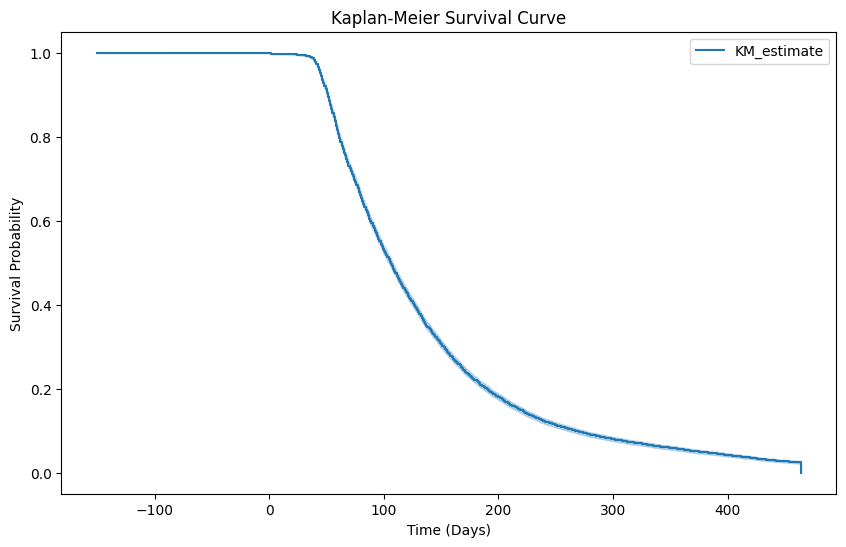

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

cox_data = filled_data.drop('Serial', axis=1).copy()
cox_data['Event'] = 1
# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier estimator to your data
kmf.fit(durations=cox_data['DaysOpen'], event_observed=cox_data['Event'])

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

# Set the dark theme
pio.templates.default = "plotly_dark"


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\gheys\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/15.6 MB 1.3 MB/s eta 0:00:13
     ---------------------------------------- 0.0/15.6 MB 1.3 MB/s eta 0:00:13
     ---------------------------------------- 0.0/15.6 MB 1.3 MB/s eta 0:00:13
     ---------------------------------------- 0.0/15.6 MB 1.3 MB/s eta 0:00:13
     ---------------------------------------- 0.0/15.6 MB 1.3 MB/s eta 0:00:13
     ---------------------------------------- 0.0/15.6 MB 1.3 MB/s eta 0:00:13
     ---------------------------------------- 0.0/15.6 MB 1.3 MB/s eta 0:00:13
     ----------

In [ ]:
# # Box Plots (Horizontal)
# fig = go.Figure()
# fig.add_trace(go.Box(x=filled_data['DaysOpen'], name='Days Open', orientation='h'))  # Set orientation to 'h' for horizontal
# fig.update_layout(
#     title='Days Open Box Plot',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(title='Days Open', color='white'),  # Set x-axis title and font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
# )
# fig.show()


In [ ]:
# # Box Plots (Horizontal)
# fig = go.Figure()
# fig.add_trace(go.Box(x=filled_data['AgeAtCalvingInDays'], name='AgeAtCalvingInDays', orientation='h'))  # Set orientation to 'h' for horizontal
# fig.update_layout(
#     title='AgeAtCalvingInDays Box Plot',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(title='AgeAtCalvingInDays', color='white'),  # Set x-axis title and font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
# )
# fig.show()


In [ ]:
# # Seasons Pie Chart
# season_counts = filled_data[['Winter', 'Spring', 'Summer', 'Fall']].sum()
# fig = go.Figure(data=[go.Pie(labels=season_counts.index, values=season_counts.values)])
# fig.update_layout(
#     title='Seasons Pie Chart',
#     font=dict(color='white'),  # Set font color
# )
# fig.show()

In [ ]:
# import plotly.figure_factory as ff
# import numpy as np

# # Select numeric columns for correlation matrix
# numeric_columns = filled_data.select_dtypes(include=[np.number])

# # Compute correlation matrix
# corr_matrix = numeric_columns.corr()

# # Format correlation values with desired precision
# corr_values = corr_matrix.apply(lambda x: np.round(x, 2)).values.tolist()

# # Convert correlation matrix columns to a list
# corr_columns = corr_matrix.columns.tolist()

# # Create the correlation heatmap
# fig = ff.create_annotated_heatmap(
#     z=corr_values,
#     x=corr_columns,
#     y=corr_columns,
#     colorscale='Viridis',
#     colorbar=dict(title='Correlation'),
# )

# # Update layout
# fig.update_layout(
#     title='Correlation Heatmap',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(tickfont=dict(color='white')),  # Set x-axis tick font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
#     height=1500,  # Set the height of the figure
#     width=1500,  # Set the width of the figure
# )

# fig.show()


In [68]:
filled_data

,Serial,AgeAtCalvingInDays,AverageBodyScore,AverageMotionScore,InbreedingCoefficient,StillBirth,Abortion,Lactation,MultiBirth,NaturalBreeding,...,Ketosis,RetainedPlacentra,DisplacedAbomasam,Winter,Spring,Summer,Fall,AverageMilk,ECM,FatProteinRatio
4757,3251389070105150,1606.000000,2.203555,3.000000,0.000000,0,1,3.000000,0,0,...,0,0,0,1,0,0,0,33.905290,3248.499750,0.966186
4758,3251387112506750,2105.000000,2.203555,2.106707,4.687500,0,1,3.000000,0,0,...,0,0,0,0,0,0,1,36.809746,6692.513209,0.966186
4759,3251387112506750,2105.000000,2.203555,2.106707,4.687500,0,1,3.000000,0,0,...,0,0,0,0,0,0,1,36.809746,6692.513209,0.966186
4760,3251390032502390,1435.000000,2.203555,2.106707,2.742136,0,0,2.000000,0,0,...,0,0,0,0,1,0,0,31.724023,2759.418930,0.966186
4761,3251385090704880,3126.000000,2.203555,4.000000,1.129151,0,1,6.000000,0,0,...,0,0,0,0,1,1,0,28.922913,3376.431960,0.966186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,3251388033002190,2277.000000,3.909826,2.106707,0.720215,0,1,3.000000,0,0,...,0,1,0,0,0,1,1,36.809746,6692.513209,0.966186
16468,3251386091305310,3543.517517,3.909826,2.000000,0.073242,1,0,6.906012,1,0,...,0,0,0,1,0,0,1,44.493436,4233.861930,0.966186
16469,3251387012800560,2283.000000,3.909826,2.106707,0.000000,0,0,3.000000,0,0,...,0,1,0,0,0,1,0,36.809746,6692.513209,0.966186
16470,3251382030300980,2601.000000,3.909826,2.106707,0.195313,0,0,5.000000,0,1,...,0,0,0,0,0,1,0,28.428000,2231.029440,0.966186


In [69]:
len(filled_data['Serial'].unique())

4548

In [70]:
columns = filled_data.columns.to_list()
columns_to_remove = ['Serial', 'Lactation']  # Columns to remove from the sequence
feature_columns = [col for col in columns if col not in columns_to_remove]
import numpy as np

In [71]:
feature_columns

['AgeAtCalvingInDays',
 'AverageBodyScore',
 'AverageMotionScore',
 'InbreedingCoefficient',
 'StillBirth',
 'Abortion',
 'MultiBirth',
 'NaturalBreeding',
 'DaysOpen',
 'TimesBred',
 'Lameness',
 'Mastities',
 'Ketosis',
 'RetainedPlacentra',
 'DisplacedAbomasam',
 'Winter',
 'Spring',
 'Summer',
 'Fall',
 'AverageMilk',
 'ECM',
 'FatProteinRatio']

In [72]:
import numpy as np

def generate_sequences(data, feature_cols, target_column, cow_serials):
    sequences = []
    targets = []

    for cow_serial in cow_serials:
        cow_data = data[data['Serial'] == cow_serial].values
        cow_data = cow_data[np.argsort(cow_data[:, columns.index('Lactation')])]

        # Loop through different starting points for the sequences
        for start_index in range(len(cow_data)):
            for end_index in range(start_index + 1, len(cow_data) + 1):
                # Get the sequence from start_index to end_index
                seq_data = cow_data[start_index:end_index]
                targets.append(seq_data[-1, columns.index(target_column)])  # Target is the last record in the sequence

                # Remove serial and lactation columns from the sequence
                seq_data = np.delete(seq_data, [columns.index(col) for col in columns_to_remove], axis=1)

                sequences.append(seq_data)

    return sequences, targets

def split_data(data, validation_ratio=0.1, test_ratio=0.2):
    unique_serials = data['Serial'].unique()
    np.random.shuffle(unique_serials)

    num_samples = len(unique_serials)
    num_validation = int(num_samples * validation_ratio)
    num_test = int(num_samples * test_ratio)

    validation_serials = unique_serials[:num_validation]
    test_serials = unique_serials[num_validation:num_validation + num_test]
    train_serials = unique_serials[num_validation + num_test:]

    train_sequences, train_targets = generate_sequences(data, feature_columns, 'DaysOpen', train_serials)
    val_sequences, val_targets = generate_sequences(data, feature_columns, 'DaysOpen', validation_serials)
    test_sequences, test_targets = generate_sequences(data, feature_columns, 'DaysOpen', test_serials)

    return train_sequences, train_targets, val_sequences, val_targets, test_sequences, test_targets

train_sequences, train_targets, val_sequences, val_targets, test_sequences, test_targets = split_data(filled_data)

# Checking the shapes
print("Shape of train sequences:", len(train_sequences))
print("Shape of train targets:", len(train_targets))
print("Shape of validation sequences:", len(val_sequences))
print("Shape of validation targets:", len(val_targets))
print("Shape of test sequences:", len(test_sequences))
print("Shape of test targets:", len(test_targets))
print("Shape of each train sequence:", train_sequences[1200].shape)
print("Shape of each validation sequence:", val_sequences[0].shape)
print("Shape of each test sequence:", test_sequences[0].shape)


Shape of train sequences: 18059
Shape of train targets: 18059
Shape of validation sequences: 2828
Shape of validation targets: 2828
Shape of test sequences: 5413
Shape of test targets: 5413
Shape of each train sequence: (1, 22)
Shape of each validation sequence: (1, 22)
Shape of each test sequence: (1, 22)


In [73]:
filled_data['Serial'].unique().shape

(4548,)

In [74]:
# import matplotlib.pyplot as plt

# def plot_sequence_lengths(sequences):
#     # Calculate the lengths of each sequence
#     sequence_lengths = [seq.shape[0] for seq in sequences]

#     # Create the bar chart
#     plt.figure(figsize=(10, 6))
#     plt.bar(range(len(sequence_lengths)), sequence_lengths)
#     plt.xlabel('Sequence Index')
#     plt.ylabel('Sequence Length')
#     plt.title('Lengths of Sequences')
#     plt.show()

# # Plot for train sequences
# plot_sequence_lengths(train_sequences)

# # Plot for validation sequences
# plot_sequence_lengths(val_sequences)

# # Plot for test sequences
# plot_sequence_lengths(test_sequences)


In [75]:
# import plotly.graph_objects as go

# def plot_sequence_length_distribution(sequences):
#     # Calculate the lengths of each sequence
#     sequence_lengths = [seq.shape[0] for seq in sequences]

#     # Calculate the count of sequences for each length
#     sequence_length_counts = {length: sequence_lengths.count(length) for length in range(1, max(sequence_lengths) + 1)}

#     # Create the bar plot
#     fig = go.Figure(data=[go.Bar(x=list(sequence_length_counts.keys()), y=list(sequence_length_counts.values()))])
#     fig.update_layout(title='Distribution of Sequence Lengths',
#                       xaxis_title='Sequence Length',
#                       yaxis_title='Count',
#                       xaxis=dict(dtick=1),
#                       yaxis=dict(type='log', dtick=1))

#     fig.show()

# # Plot for train sequences
# plot_sequence_length_distribution(train_sequences)

# # Plot for validation sequences
# plot_sequence_length_distribution(val_sequences)

# # Plot for test sequences
# plot_sequence_length_distribution(test_sequences)


In [76]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad_and_stack_sequences(sequences, targets, max_sequence_length=15):
    # Padding sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='pre', dtype='float32')

    # Stacking padded sequences
    X = np.stack(padded_sequences)
    y = np.array(targets)

    return X, y

# Padding and stacking for train sequences
X_train, y_train = pad_and_stack_sequences(train_sequences, train_targets, max_sequence_length=10)

# Padding and stacking for validation sequences
X_val, y_val = pad_and_stack_sequences(val_sequences, val_targets, max_sequence_length=10)

# Padding and stacking for test sequences
X_test, y_test = pad_and_stack_sequences(test_sequences, test_targets, max_sequence_length=10)

# Checking the shape
print("Shape of X_train:", X_train.shape)  # Shape of the stacked and padded train sequences (num_sequences, max_sequence_length, num_features)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)  # Shape of the stacked and padded validation sequences (num_sequences, max_sequence_length, num_features)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)  # Shape of the stacked and padded test sequences (num_sequences, max_sequence_length, num_features)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (18059, 10, 22)
Shape of y_train: (18059,)
Shape of X_val: (2828, 10, 22)
Shape of y_val: (2828,)
Shape of X_test: (5413, 10, 22)
Shape of y_test: (5413,)


In [77]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Fitting the normalizer to X_train
scaler = StandardScaler()
scaler.fit(X_train.reshape(-1, X_train.shape[-1]))  # Reshape the data to 2D for fitting the scaler

# Transforming X_train, X_val, and X_test
X_train = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)



storage["scaler"] = scaler

# Checking the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (18059, 10, 22)
Shape of X_val: (2828, 10, 22)
Shape of X_test: (5413, 10, 22)


In [78]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking, TimeDistributed, Flatten
from keras import backend as K

# Activate matplotlib interactive mode
plt.ion()


In [79]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from itertools import product

# Assuming 'cox_data' is your DataFrame
# Split your data into a training set and a test set
train_data, test_data = train_test_split(cox_data, test_size=0.2, random_state=42)  # Adjust test_size as needed

# Define the hyperparameter grid
alpha_values = [0.01, 0.05, 0.1]  # Example values for alpha
n_baseline_knots_values = [2, 4, 6]  # Example values for n_baseline_knots
l1_ratio_values = [0.0, 0.5, 1.0]  # Example values for l1_ratio

# Initialize variables to store the best hyperparameters and C-index
best_params = {}
best_c_index = 0.0

# Iterate over all combinations of hyperparameters
for alpha, n_baseline_knots, l1_ratio in product(alpha_values, n_baseline_knots_values, l1_ratio_values):
    # Initialize Cox proportional hazards model with current hyperparameters
    coxph = CoxPHFitter(alpha=alpha, n_baseline_knots=n_baseline_knots, l1_ratio=l1_ratio)

    # Fit the Cox model to the training data
    coxph.fit(train_data, duration_col='DaysOpen', event_col='Event')

    # Use the Cox model to predict median survival time
    predicted_median_survival_time = coxph.predict_expectation(test_data)

    # Extract the observed event times and event indicators from the test data
    observed_times = test_data['DaysOpen']
    event_observed = test_data['Event']

    # Calculate the C-index
    c_index = concordance_index(observed_times, predicted_median_survival_time, event_observed)

    # Check if the current hyperparameters yield a better C-index
    if c_index > best_c_index:
        best_c_index = c_index
        best_params = {'alpha': alpha, 'n_baseline_knots': n_baseline_knots, 'l1_ratio': l1_ratio}

# Print the best hyperparameters and C-index
print("Best Hyperparameters:", best_params)
print("Best Concordance Index (C-index):", best_c_index)


Best Hyperparameters: {'alpha': 0.01, 'n_baseline_knots': 2, 'l1_ratio': 0.0}
Best Concordance Index (C-index): 0.8017078394758764


In [80]:
# After the loop, use the best hyperparameters to train the model
best_alpha = best_params['alpha']
best_n_baseline_knots = best_params['n_baseline_knots']
best_l1_ratio = best_params['l1_ratio']

# Initialize Cox proportional hazards model with the best hyperparameters
coxph_best = CoxPHFitter(alpha=best_alpha, n_baseline_knots=best_n_baseline_knots, l1_ratio=best_l1_ratio)

# Fit the Cox model to the training data with the best hyperparameters
coxph_best.fit(train_data, duration_col='DaysOpen', event_col='Event')

predicted_median_survival_time = coxph_best.predict_expectation(test_data)


In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, GRU, Dense

def get_model(model_type='LSTM'):
    if model_type == 'LSTM':
        rnn_layer_1 = LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
        rnn_layer_2 = LSTM(32)
    elif model_type == 'BiLSTM':
        rnn_layer_1 = Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        rnn_layer_2 = Bidirectional(LSTM(32))
    elif model_type == 'RNN':
        rnn_layer_1 = SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
        rnn_layer_2 = SimpleRNN(32)
    else:
        raise ValueError("Invalid model_type. Choose from 'LSTM', 'BiLSTM', 'RNN', or 'GRU'.")

    model = Sequential()
    model.add(rnn_layer_1)
    model.add(rnn_layer_2)
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model


In [82]:
from IPython.display import clear_output

def train_model(model_type, train_X, train_y, val_X, val_y, patience=3):
    model = get_model(model_type)

    # Initialize lists for storing MAE values and attention weights
    train_mae = []
    val_mae = []
    train_seq_lengths = [len(seq) for seq in train_X]

    best_val_mae = float('inf')
    epochs_without_improvement = 0

    for epoch in range(1, 3):  # You can adjust the maximum number of epochs here
        history = model.fit(train_X, train_y, epochs=1, batch_size=32, validation_data=(val_X, val_y),
                            sample_weight=np.array(train_seq_lengths), verbose=0)

        # Update lists with MAE values
        train_mae.append(history.history['mean_absolute_error'][0])
        val_mae.append(history.history['val_mean_absolute_error'][0])

        # Check for early stopping
        if val_mae[-1] < best_val_mae:
            best_val_mae = val_mae[-1]
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping after {epoch} epochs.")
                break

        clear_output(wait=True)
        fig = plt.figure(figsize=(10, 6))
        plt.plot(train_mae, label='Train MAE')
        plt.plot(val_mae, label='Val MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.title(f'Training Process of {model_type} model')
        plt.legend()
        plt.grid(True)
        plt.yticks(np.arange(0, max(train_mae + val_mae), 5))
        plt.show()

    # Deactivate matplotlib interactive mode
    plt.ioff()

    return model


In [83]:
models = {
    "LSTM": None,
    "BiLSTM": None,
    "RNN": None,
}
# models["LSTM"] = train_model("LSTM", X_train, y_train, X_val, y_val)
# models["BiLSTM"]  = train_model("BiLSTM", X_train, y_train, X_val, y_val)
# models["RNN"]  = train_model("RNN", X_train, y_train, X_val, y_val)

In [84]:
# from tensorflow.keras.utils import plot_model

# plot_model(models["RNN"], to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# from IPython.display import Image, display

# # Assuming 'model_plot.png' is the file name
# display(Image(filename='model_plot.png'))

In [85]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    # Use the model to make predictions
    y_pred = model.predict(X_test)

    # Flatten the predictions to 1D arrays
    y_test_flattened = y_test.flatten()
    y_pred_flattened = y_pred.flatten()

    # Calculate evaluation metrics
    mae_val = mean_absolute_error(y_test_flattened, y_pred_flattened)
    mse_val = mean_squared_error(y_test_flattened, y_pred_flattened)
    r2_val = r2_score(y_test_flattened, y_pred_flattened)
    c_index = concordance_index(y_test_flattened, -y_pred_flattened)

    return mae_val, mse_val, r2_val, c_index


In [86]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

def evaluate_cox_model(test_data, predicted_median_survival_time):
    # Extract the observed event times and event indicators from the test data
    observed_times = test_data['DaysOpen']
    event_observed = test_data['Event']

    # Filter out infinite values from observed_times and predicted_median_survival_time
    finite_mask = np.isfinite(observed_times) & np.isfinite(predicted_median_survival_time)
    observed_times_finite = observed_times[finite_mask]
    predicted_median_survival_time_finite = predicted_median_survival_time[finite_mask]

    # Calculate the C-index
    c_index = concordance_index(observed_times_finite, predicted_median_survival_time_finite, event_observed[finite_mask])

    # Calculate Mean Absolute Error (MAE) for Survival, ignoring infinite values
    mae_survival = mean_absolute_error(observed_times_finite, predicted_median_survival_time_finite)

    # Calculate Mean Squared Error (MSE) for Survival, ignoring infinite values
    mse_survival = mean_squared_error(observed_times_finite, predicted_median_survival_time_finite)

    # Calculate R2 score for Survival, ignoring infinite values
    r2_survival = r2_score(observed_times_finite, predicted_median_survival_time_finite)

    return c_index, mae_survival, mse_survival, r2_survival

# # Assuming 'cox_predicted_survival_time' contains the predicted survival times from the Cox model
# cox_evaluation_results = evaluate_cox_model(test_data, predicted_median_survival_time)

# # Create a dictionary to store the model types and their corresponding evaluation metrics
# model_types = ['LSTM', 'BiLSTM', 'RNN', 'Cox']
# evaluation_results = {'Cox': dict(zip(['C-Index', 'MAE', 'MSE', 'R2'], cox_evaluation_results))}

# # Evaluate each trained model
# for model_type in model_types[:-1]:  # Exclude 'Cox' from this loop
#     print(model_type)
#     model = models[model_type]
#     mae_val, mse_val, r2_val, c_index = evaluate_model(model, X_test, y_test)
#     evaluation_results[model_type] = {'MAE': mae_val, 'MSE': mse_val, 'R2': r2_val, 'C-Index': c_index}

# # Create a table using Matplotlib
# fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the figure size as needed
# rows = ['C-Index', 'MAE', 'MSE', 'R2']
# columns = list(evaluation_results.keys())
# cell_text = [
#     [f'{evaluation_results[model][row]:.4f}' if isinstance(evaluation_results[model][row], float) else evaluation_results[model][row] for model in columns]
#     for row in rows
# ]
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=cell_text, colLabels=columns, rowLabels=rows, loc='center')
# plt.show()


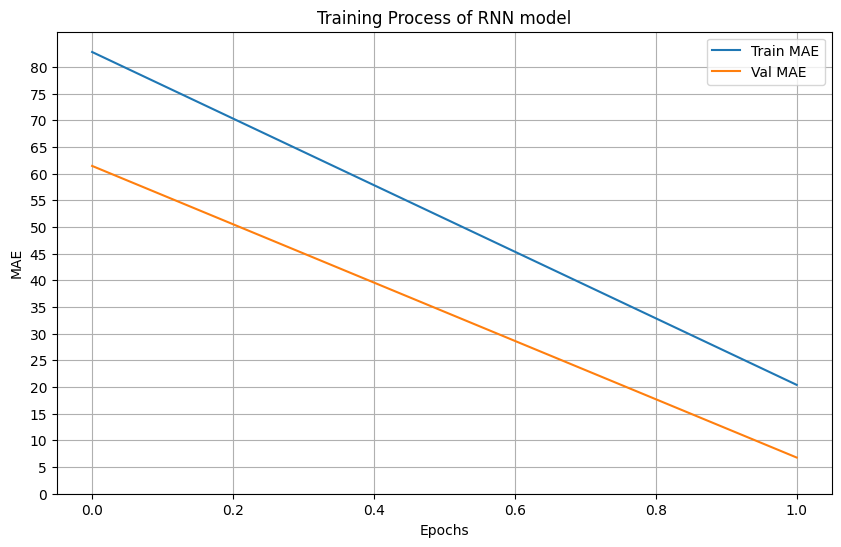

170/170 [==============================] - 1s 3ms/step


In [87]:
# Define the number of training runs
num_training_runs = 2

# Create a dictionary to store evaluation results
evaluation_results = {model_type: {metric: [] for metric in ['C-Index', 'MAE', 'MSE', 'R2']} for model_type in ['LSTM', 'BiLSTM', 'RNN', 'Cox']}

# Perform multiple training runs
for run in range(num_training_runs):
    print(f"Training Run {run + 1}")

    # Train RNN models
    for model_type in ['LSTM', 'BiLSTM', 'RNN']:
        print(f"Training {model_type}")
        models[model_type] = train_model(model_type, X_train, y_train, X_val, y_val)

        # Evaluate the model
        mae_val, mse_val, r2_val, c_index = evaluate_model(models[model_type], X_test, y_test)
        evaluation_results[model_type].get('MAE').append(mae_val)
        evaluation_results[model_type].get('MSE').append(mse_val)
        evaluation_results[model_type].get('R2').append(r2_val)
        evaluation_results[model_type].get('C-Index').append(c_index)

    # Train Cox model
    coxph_best = CoxPHFitter(alpha=best_alpha, n_baseline_knots=best_n_baseline_knots, l1_ratio=best_l1_ratio)
    coxph_best.fit(train_data, duration_col='DaysOpen', event_col='Event')

    # Evaluate the Cox model
    cox_evaluation_results = evaluate_cox_model(test_data, coxph_best.predict_expectation(test_data))
    for metric, value in zip(['C-Index', 'MAE', 'MSE', 'R2'], cox_evaluation_results):
        evaluation_results['Cox'][metric].append(value)


In [90]:
from tabulate import tabulate

# Define the number of training runs and models
num_training_runs = 2
model_names = ['LSTM', 'BiLSTM', 'RNN', 'Cox']
metrics = ['C-Index', 'MAE', 'MSE', 'R2']

# Create a list to store the results
results = []

# Iterate over training runs
for run in range(num_training_runs):
    row = [f'Experiment {run + 1}']

    # Iterate over models
    for model_type in model_names:
        # Iterate over metrics
        for metric in metrics:
            # Append results to the row
            row.append(f'{model_type} - {metric}: {evaluation_results[model_type][metric][run]:.4f}')

    # Append row to the results
    results.append(row)

# Define the headers for the table
headers = ['Experiment'] + [f'{model} - {metric}' for model in model_names for metric in metrics]

# Print the table
print(tabulate(results, headers, tablefmt="grid"))


+--------------+------------------------+---------------------+------------------------+--------------------+--------------------------+----------------------+------------------------+---------------------+-----------------------+-------------------+---------------------+------------------+-----------------------+---------------------+-----------------------+-------------------+
| Experiment   | LSTM - C-Index         | LSTM - MAE          | LSTM - MSE             | LSTM - R2          | BiLSTM - C-Index         | BiLSTM - MAE         | BiLSTM - MSE           | BiLSTM - R2         | RNN - C-Index         | RNN - MAE         | RNN - MSE           | RNN - R2         | Cox - C-Index         | Cox - MAE           | Cox - MSE             | Cox - R2          |
+==============+========================+=====================+========================+====================+==========================+======================+========================+=====================+=======================+======

In [91]:
print(np.any(np.isinf(predicted_median_survival_time)))
print(np.any(np.isinf(observed_times)))


False
False


In [92]:
print(evaluation_results)

{'LSTM': {'C-Index': [0.07345843612738304, 0.3574330529889431], 'MAE': [26.667054375810736, 68.57874959702642], 'MSE': [2703.21667771891, 10730.246322325296], 'R2': [0.7275781863273096, -0.08136102754043928]}, 'BiLSTM': {'C-Index': [0.018662009730166434, 0.018889984305540605], 'MAE': [7.629750091695331, 4.701112136082569], 'MSE': [373.0394447716169, 89.99157806244877], 'R2': [0.9624062388510076, 0.9909309271753506]}, 'RNN': {'C-Index': [0.028204280880337662, 0.03130752382725833], 'MAE': [5.465496261657054, 6.765064640754192], 'MSE': [82.11341855273595, 106.48717418455176], 'R2': [0.9917248637175924, 0.989268552031606]}, 'Cox': {'C-Index': [0.8017078394758764, 0.8017078394758764], 'MAE': [155.1926471111107, 155.1926471111107], 'MSE': [26418.444683256337, 26418.444683256337], 'R2': [-1.7825977625426974, -1.7825977625426974]}}


In [93]:
X_train.shape

(18059, 10, 22)

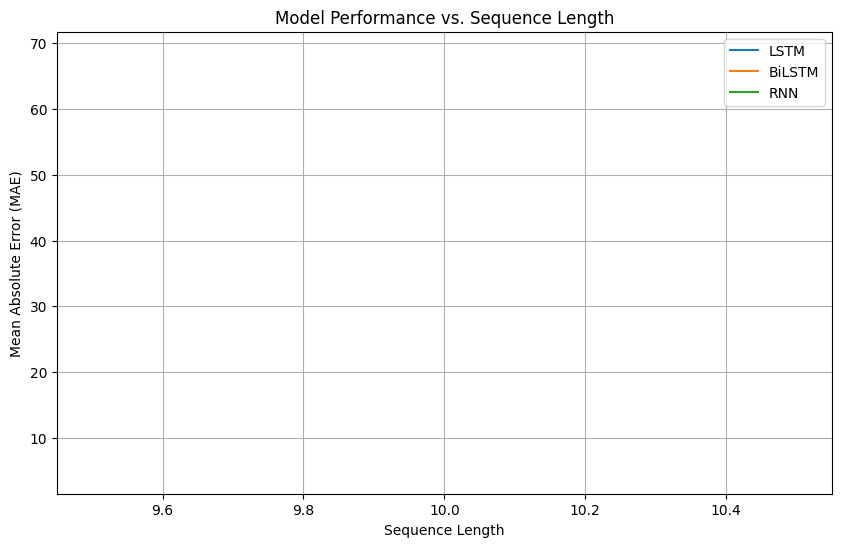

In [94]:
import matplotlib.pyplot as plt

# Define a function to evaluate models on sequences of different lengths
def evaluate_on_sequence_length(model, X, y, max_sequence_length):
    mae_values = []

    for seq_length in range(1, max_sequence_length + 1):
        # Filter sequences with the specified length
        indices = [i for i, seq in enumerate(X) if len(seq) == seq_length]
        if len(indices) > 0:
            X_subset = X[indices]
            y_subset = y[indices]

            # Calculate MAE
            mae = model.evaluate(X_subset, y_subset, verbose=0)[1]
            mae_values.append(mae)
        else:
            mae_values.append(None)

    return mae_values

# Define max sequence length
max_sequence_length = 10

# Initialize a dictionary to store MAE values for each model
mae_values_dict = {model_type: [] for model_type in models.keys()}

# Evaluate each model
for model_type, model in models.items():
    mae_values = evaluate_on_sequence_length(model, X_test, y_test, max_sequence_length)
    mae_values_dict[model_type] = mae_values

# Create the plot
plt.figure(figsize=(10, 6))
for model_type, mae_values in mae_values_dict.items():
    plt.plot(range(1, max_sequence_length + 1), mae_values, label=model_type)

plt.xlabel('Sequence Length')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model Performance vs. Sequence Length')
plt.legend()
plt.grid(True)
plt.show()


165/165 [==============================] - 1s 3ms/step
MAE After Permutition of AgeAtCalvingInDays : 4.705634533204175
165/165 [==============================] - 1s 3ms/step
MAE After Permutition of AverageBodyScore : 4.791195257450862
165/165 [==============================] - 1s 3ms/step
MAE After Permutition of AverageMotionScore : 4.694445879292771
165/165 [==============================] - 1s 3ms/step
MAE After Permutition of InbreedingCoefficient : 4.199417883731031
165/165 [==============================] - 1s 3ms/step
MAE After Permutition of StillBirth : 4.285278431635783
165/165 [==============================] - 1s 3ms/step
MAE After Permutition of Abortion : 4.33011020218551
165/165 [==============================] - 1s 3ms/step
MAE After Permutition of MultiBirth : 4.347112657793451
165/165 [==============================] - 1s 3ms/step
MAE After Permutition of NaturalBreeding : 4.216844200276399
165/165 [==============================] - 1s 3ms/step
MAE After Permutition 

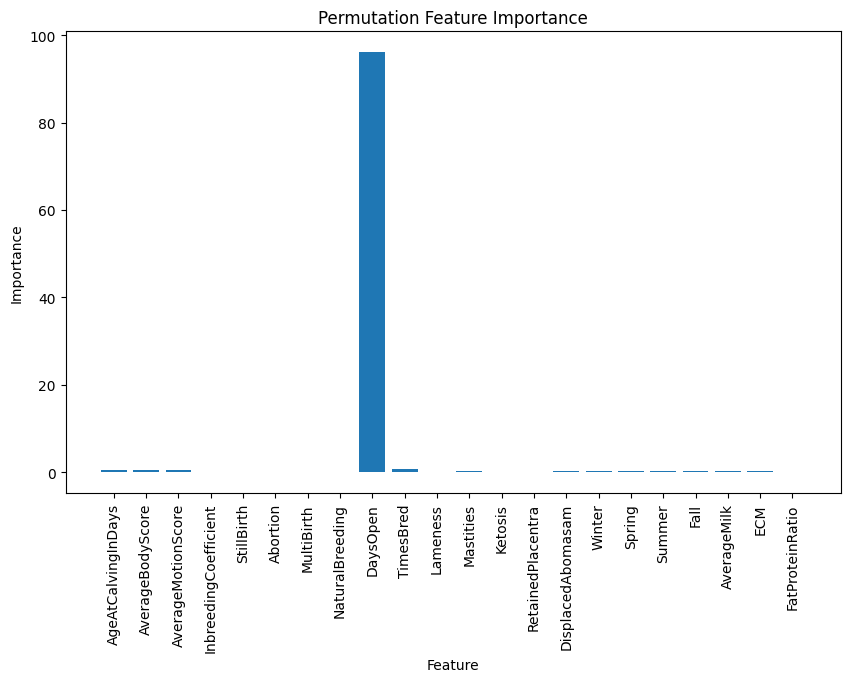

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Assume X_test and y_test are your test data
# Assume model is your trained LSTM model

# Compute the baseline performance of the model
baseline_mae = mean_absolute_error(y_test, model.predict(X_test))

# Initialize an array to hold the feature importances
feature_importances = np.zeros(X_test.shape[2])

# Loop over the features
for i in range(X_test.shape[2]):
    # Make a copy of the test data
    X_test_permuted = X_test.copy()

    # Permute the values of the feature
    for j in range(X_test.shape[1]):
        np.random.shuffle(X_test_permuted[:, j, i])

    # Compute the performance of the model on the permuted data
    mae_permuted = mean_absolute_error(y_test, model.predict(X_test_permuted))

    print(f"MAE After Permutition of {feature_columns[i]} : {mae_permuted}")

    # The feature importance is the decrease in performance
    feature_importances[i] =  mae_permuted - baseline_mae

# Plot the feature importances
# Plot the feature importances
plt.figure(figsize=(10,6))
plt.bar(feature_columns, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance')
plt.xticks(rotation='vertical')  # Rotate feature names for readability
plt.show()

In [ ]:
import pandas as pd

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Display the DataFrame
df_importances

,Feature,Importance
8,DaysOpen,96.073886
9,TimesBred,0.725525
1,AverageBodyScore,0.559866
0,AgeAtCalvingInDays,0.474306
2,AverageMotionScore,0.463117
19,AverageMilk,0.385734
14,DisplacedAbomasam,0.381064
16,Spring,0.369135
20,ECM,0.313249
11,Mastities,0.255015


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import plotly.graph_objects as go

# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', score)

# Use the model to make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Median Absolute Error (MedAE):', medae)
print('R-squared (R2):', r2)



165/165 [==============================] - 1s 4ms/step - loss: 4.2313 - mean_absolute_error: 4.2313
Test loss: [4.231328964233398, 4.231328964233398]
165/165 [==============================] - 1s 3ms/step
Mean Absolute Error (MAE): 4.2313289523204665
Mean Squared Error (MSE): 31.409344636092005
Median Absolute Error (MedAE): 3.4906463623046875
R-squared (R2): 0.9969631290174547


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


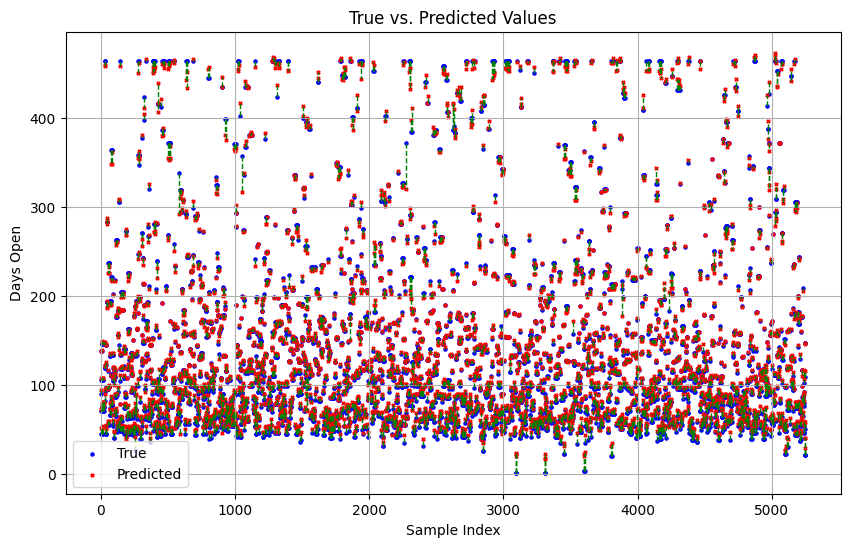

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are numpy arrays
x_values = np.arange(len(y_test))

# Round the prediction values to natural numbers
y_pred_rounded = np.round(y_pred.flatten())

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot true values in blue with smaller dots (s parameter)
plt.scatter(x_values, y_test, label='True', color='blue', marker='o', s=5)

# Plot predicted values (rounded) in red with smaller dots (s parameter)
plt.scatter(x_values, y_pred_rounded, label='Predicted', color='red', marker='x', s=5)

# Draw lines connecting true and predicted values
for x, yt, yp in zip(x_values, y_test, y_pred_rounded):
    plt.plot([x, x], [yt, yp], color='green', linestyle='--', linewidth=1)

plt.title('True vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Days Open')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:

# Distribution of true values and predicted values
fig4 = go.Figure()

# Plot histogram of true values in blue
fig4.add_trace(go.Histogram(x=y_test, nbinsx=20, name='True', marker=dict(color='blue'), opacity=0.7))

# Plot histogram of predicted values in red
fig4.add_trace(go.Histogram(x=y_pred.flatten(), nbinsx=20, name='Predicted', marker=dict(color='red'), opacity=0.7))

fig4.update_layout(title='Distribution of True vs. Predicted Values',
                   xaxis_title='Days Open',
                   yaxis_title='Frequency',
                   barmode='overlay')

fig4.update_traces(opacity=0.75)


fig4.show()


In [ ]:
print(y_pred.squeeze().shape, y_test.squeeze().shape)

(5251,) (5251,)


In [ ]:


# Calculate percentage of predicted values greater than actual test values
greater_count = np.sum(y_pred.squeeze() > y_test.squeeze())
greater_percentage = greater_count / y_pred.squeeze().shape[0] * 100

# Calculate percentage of predicted values lower than actual test values
lower_count = np.sum(y_pred.squeeze() < y_test.squeeze())
lower_percentage = lower_count / y_pred.squeeze().shape[0] * 100

# Create a bar chart
fig = go.Figure(data=[go.Bar(x=['Greater', 'Lower'], y=[greater_percentage, lower_percentage])])
fig.update_layout(title='Percentage of Predicted Values Greater/Lower Than Actual Test Values')
fig.show()